In [51]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import os
from io import BytesIO
from csv import writer 

import pandas as pd

import nltk
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer as lm
from nltk import Text
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize as sentoken
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
retokenize = RegexpTokenizer("[\w]+")

In [2]:
#리뷰 불러오기
path = 'C:/Users/taehee/Documents/GitHub/tripReviewAnalysisSystem/크롤러-전처리/원시자료/'
deoksugung = pd.read_csv(path+'Deoksugung.csv', engine='python', index_col = 0, encoding = 'utf-8')

deoksugung.head()

,star_point,title,text,Date of experience
0,4.0,"Small City Palace, Great for Visit if one is s...",A small palace compared to that of Gyeongbukgu...,November 2019
1,5.0,My favorite Palace,This is probably one of my most favorite Palac...,January 2020
2,5.0,Love of Beauty is Taste. The Creation of Beaut...,There is a common believe that most South Kore...,January 2020
3,5.0,Deoksugung is a unique palace,I visited 2 palaces (Deoksugung & Gyeongbokgun...,December 2019
4,5.0,Plan to Visit here and the other Historical Pl...,Why pay for tour guides when you can hop on an...,January 2020


In [3]:
# 별점에 따라 쪼개기
deoksugung["star_point"].unique()

array([4., 5., 3., 2.])

In [4]:
deoksugung_4 = deoksugung[deoksugung["star_point"]==4]
deoksugung_4.head()

,star_point,title,text,Date of experience
0,4.0,"Small City Palace, Great for Visit if one is s...",A small palace compared to that of Gyeongbukgu...,November 2019
6,4.0,Changing of the guard,I've been here a few times over the years and ...,November 2019
8,4.0,Changing of the guards,This is a much smaller palace as compared to t...,April 2019
10,4.0,Lovely autumn colours,Deoksugung is right at City Hall Station. I we...,November 2019
11,4.0,Great palace to visit at night,Deoksugung is the only palace open at night an...,September 2019


In [7]:
#과제 : 리팩토링하자. for문을 행렬화하자.

def attraction_12345(attraction):
    attraction_12345 = []
    for num in range(1,5+1):
        attraction_n = attraction[attraction["star_point"]==num]
        attraction_n_text =''
        for text in attraction_n['text']:
            attraction_n_text += (" " + text)
        ##다 소문자로 만들자. 컴퓨터는 The와 the가 다른 걸 모른다...
        lower_text_n = attraction_n_text.lower()
        print(str (num) + "     " + lower_text_n[:100])
        token_n = retokenize.tokenize(lower_text_n)
        Text_n = Text(token_n)
        attraction_12345.append((lower_text_n, Text_n))
        
    return attraction_12345

1     
2      we ventured here for the free rental of hanbok, and the changing of guards performance:  changing o
3      deoksugung  palace was used by the king when he was in exile during the japanese invasion of 1592. 
4      a small palace compared to that of gyeongbukgung and changdeokgung. this palace is perfect for thos
5      this is probably one of my most favorite palace in seoul, definitely in the top three. it seems lik


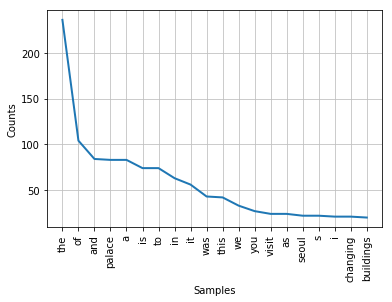

In [8]:
deoksugung_12345 = attraction_12345(deoksugung)
deoksugung_12345[5 -1][1].plot(20)
plt.show()

보면 알겠지만 the and 따위가 너무 많이 나온다.
불용어 = 쓸모 없는 단어 사전을 불러온다
NLTK랑 별도로 미리 다운로드 해둬야 한다.
http://www.nltk.org/data.html 참조

In [9]:
stop_words = set(stopwords.words('english')) 
stop_words|set(['.', ',', 'the', "'s"])

{"'s",
 ',',
 '.',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 

그리고 동사나 여러 친구들도 원형으로 복원하기 위해서...
sentoken으로 문장으로 나눠주고
pos_tag로 각 단어의 품사를 찾고
lm을 써서 원형으로 복원한다

In [10]:
test_text = 'We ventured here for the free rental of Hanbok, and the changing of guards performance:  Changing of Guards ceremony Closed on Mondays.  We queued for the Hanbok, as the sign stated that the counter will be opened at'

In [11]:
def root_text_12345(attraction_12345):
    result_12345 = []
    for (lower_text_n, Text_n) in attraction_12345:
        sentences = sentoken(lower_text_n)
        result_n = []
        for sentence in sentences:
            test_words = retokenize.tokenize(sentence)
            tagged_tokens = pos_tag(test_words, tagset='universal')
            for (token, tag) in tagged_tokens:
                if token not in stop_words:
                    try:
                        root = lm.lemmatize(lm, word = token, pos = tag)
                    except KeyError:
                        root = token
                    result_n.append(root)
        result_12345.append(Text(result_n))
    return result_12345

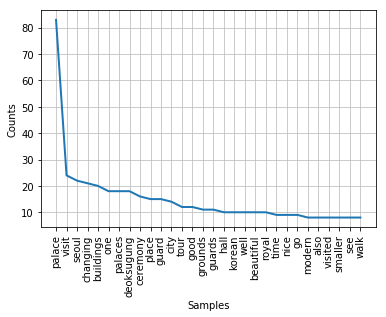

In [12]:
root_text_5 = root_text_12345(deoksugung_12345)[5-1]
#빈도순 그래프를 보여준다
root_text_5.plot(30)
plt.show()

어간 추출을 했음에도... 단수와 복수는 구분한다. 생각해보면 사람 한 명과 여러 사람은 다르니까. 엄격히 따지면 맞는 말이다.

그러면 어떤 기준으로 동의어를 구분해야 할까?

In [13]:
#별점 5점인 리뷰들
deoksugung_text_5 = Text(retokenize.tokenize(deoksugung_12345[5 -1][0]))
#단어가 쓰인 문맥을 보여준다
deoksugung_text_5.concordance("palaces")

Displaying 18 of 18 matches:
so has a lot of dynamic i visited 2 palaces deoksugung gyeongbokgung during my 
l scenery this was the last of four palaces that we visited while in seoul and 
ok deoksugung is one of the 5 royal palaces in seoul it is covered by the royal
l palace compared to the other main palaces but i think one of the nicer and mo
considered one among the five grand palaces of joseon dynasty located near the 
y i seriously fell in love with the palaces in seoul this one is definitely def
it s pretty small compared to other palaces it s still beautiful one of the bui
ot just as a spectator unlike other palaces you can also enter the palace groun
 it although smaller than the other palaces this place is packed with charm the
t is the smallest of the five royal palaces in korea the palace building is a b
visit because you see many types of palaces in one place i recommend it to ever
 would be a much better of the five palaces in the heart of seoul the deoksugun
istory this

문맥을 보면 palaces는 덕수궁을 다른 궁궐과 비교할 때 많이 쓰는 모양이다. 이를 수학적으로 보여주는 함수도 있다.

In [16]:
#similar함수는 언어학적으로 주변 문맥을 탐색해서 비슷하게 쓰인 동의어를 찾아준다.
# palace의 동의어는 place 뿐이다.
context_5 = nltk.text.ContextIndex(root_text_5)

In [17]:
context_5.similar_words("palace")

['location', 'quite', 'place']

In [18]:
#반면에 경비병과 경비병들은 동의어로 나온다. 믿을만하다.
context_5.similar_words("guard")

['guards']

In [19]:
#빈도의 리스트도 필요하다.
fd_5 = root_text_5.vocab()
fd_5.most_common(20)

[('palace', 83),
 ('visit', 24),
 ('seoul', 22),
 ('changing', 21),
 ('buildings', 20),
 ('one', 18),
 ('palaces', 18),
 ('deoksugung', 18),
 ('ceremony', 16),
 ('place', 15),
 ('guard', 15),
 ('city', 14),
 ('tour', 12),
 ('good', 12),
 ('grounds', 11),
 ('guards', 11),
 ('hall', 10),
 ('korean', 10),
 ('well', 10),
 ('beautiful', 10)]

In [20]:
fd2 = nltk.FreqDist()
fd2['taehee'] = 2
fd2['taehee'] += 1
fd2['taehee']

3

In [21]:
test_rabbit = [('taehee',3),('rabbit',2)]
test_rabbit.remove(('taehee',3))
test_rabbit

[('rabbit', 2)]

In [22]:
#동의어를 그룹지어 준다다
def find_synonym_groups(context, fd):
    result = []
    all_words = fd.most_common()
    all_dict = dict(all_words)
    for (word, times) in all_words:                
        try:
            synonyms = context.similar_words(word)
            new_word = [word]
            for synonym in synonyms:
                new_word.append(synonym)
                synonym_times = all_dict[synonym]
                try:
                    all_words.remove((synonym, synonym_times))
                except ValueError:
                    continue
                except KeyError:
                    continue
                    
            result.append(new_word)
            
        except TypeError:
            result.append(word)
        except KeyError:
            continue
            
    return result

In [23]:
synonym_groups_5 = find_synonym_groups(context_5, fd_5)

In [24]:
synonym_groups_5[:3]

[['palace', 'location', 'quite', 'place'],
 ['visit', 'grounds'],
 ['seoul', 'think']]

In [25]:
from wordcloud import (WordCloud, get_single_color_func)

# 아래 두 함수는 저도 복붙해온 것이니 이해하려 하지 마십시오오

class SimpleGroupedColorFunc(object):
    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)

class GroupedColorFunc(object):

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func
        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

In [26]:
from random import randint
def random_color_to_groups(groups):
    result = {}
    for n, group in enumerate(groups):
        
        red_value = randint(100,255)
        green_value = randint(0,255 - int(red_value/2))
        blue_value = randint(0,255 - int((red_value+green_value)/2))
    
        rgb = [red_value,green_value,blue_value]
        rgb_color = "#"
        for color in rgb:
            if color < 16:
                rgb_color += "0"+hex(color)[-1]
            else:
                rgb_color += hex(color)[-2:]
        result[rgb_color] = group
    return result

In [27]:
import numpy as np
from PIL import Image
import os

mask_palace = np.array(Image.open("C:/Users/taehee/Pictures/palace3.png"))

In [28]:
wc_mask = WordCloud(background_color="white", max_words=500, mask = mask_palace, contour_width=2, contour_color='#ff9933', width=500, height=500)
wc = WordCloud(background_color="white", max_words=500, contour_width=2, contour_color='#ff9933', width=500, height=500)

default_color = 'grey'
wc.generate_from_frequencies(fd_5)
grouped_color_func = GroupedColorFunc(random_color_to_groups(synonym_groups_5), default_color)
wc.recolor(color_func=grouped_color_func)

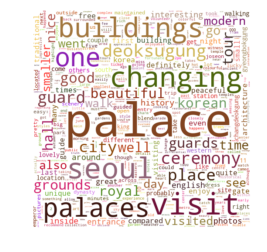

In [29]:
plt.figure()
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [91]:
def star_to_color(word_avg_star):
    result = {}
    
    avg_stars = list(word_avg_star.values())
    print(avg_stars[:10])
    sns.distplot(avg_stars)
    plt.title("단어별 별점 분포")
    plt.show()
    
    for (word, avg_star) in word_avg_star.items():
        
        green_value = int(215 * (avg_star / 4))
        
        if green_value <16:
            green_hex = "0"+ hex(green_value)[-1]
        else:
            green_hex = hex(green_value)[-2:]
        
        rgb_color = "#ff" + green_hex + "00"
        
        if rgb_color not in result:
            result[rgb_color] = [word]
        else:
            result[rgb_color].append(word)
    return result

In [87]:
def word_avgstar(root_12345):
    total_star = {}
    total_freq = {}
    
    for n, root_n in enumerate(root_12345):
        freq_n = root_n.vocab()
        freq_n_words = freq_n.most_common()
        
        for (word, freq) in freq_n_words:
            if word not in total_freq:
                total_star[word] = n * freq
                total_freq[word] = freq
            else:
                total_star[word] += n * freq
                total_freq[word] += freq
    
    result ={}
    for word in total_freq.keys():
        result[word] = float(total_star[word]) / float(total_freq[word])
    return total_freq, result

In [93]:
def word_cloud_test(data):
    '''
    입력 리뷰 데이터 프레임을 넣으면
    출력 각 단어별로 긍정 부정 가중치가 매겨진 워드클라우드가
    '''    
    #별점별로 나누기
    #별점별로 합치고 소문자로 
    data_12345 = attraction_12345(data)
    #불용어 제거하고, 어근만 남기기
    root_12345 = root_text_12345(data_12345)

    #단어별 평균 별점 계산
    #     total_star = pd.DataFrame(columns = ['total_star', 'total_freq'])
    total_freq, word_avg_star = word_avgstar(root_12345)
    
    wc_mask = WordCloud(background_color="white", max_words=500, mask = mask_palace, contour_width=2, contour_color='#ff9933', width=500, height=500)
    wc = WordCloud(background_color="white", max_words=500, contour_width=2, contour_color='#ff9933', width=500, height=500)

    #단어별 평균 별점과 총 빈도수를 반영해, 워드클라우드 생성
    
    default_color = 'grey'
    wc.generate_from_frequencies(total_freq)
    grouped_color_func = GroupedColorFunc(star_to_color(word_avg_star), default_color)
    wc.recolor(color_func=grouped_color_func)
    
    plt.figure()
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()


1     
2      we ventured here for the free rental of hanbok, and the changing of guards performance:  changing o
3      deoksugung  palace was used by the king when he was in exile during the japanese invasion of 1592. 
4      a small palace compared to that of gyeongbukgung and changdeokgung. this palace is perfect for thos
5      this is probably one of my most favorite palace in seoul, definitely in the top three. it seems lik
[2.9642857142857144, 2.625, 3.111111111111111, 3.021276595744681, 2.0, 1.0, 3.0952380952380953, 1.0, 2.5, 3.196078431372549]


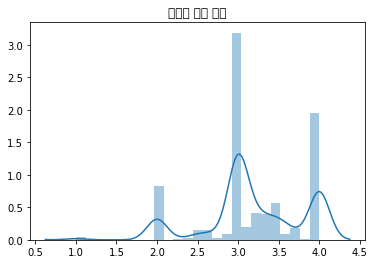

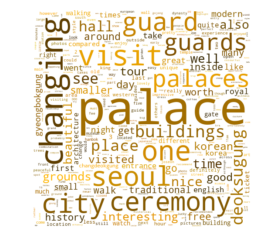

In [94]:
word_cloud_test(deoksugung)

In [ ]:
# for과 append를 행렬화하자. 더 효율적인 알고리즘.

def add_row(df, row):
    '''
    입력 : 데이터 프레임과, 새로 추가할 행의 리스트
    출력 : 행이 추가된 데이터 프레임
    '''
    output = BytesIO()
    csv_writer = writer(output)
    csv_writer.writerow(row)
    output.seek(0) # we need to get back to the start of the BytesIO
    new_row = 
    new_df = pd.concat(df, pd.read_csv(output), ignore_index = True)
    return new_df